In [1]:
import numpy as np
import torch
import ot
import matplotlib.pylab as pl
import ot.plot
import time
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

In [2]:
import sys
sys.path.append('../../code/')
sys.path.append('../../code/ot_mmd/')
sys.path.append('../../code/Latent_OT')
from generate_data import make_data
from mmdot import solve_apgd
from mmdot_mirror_descent import solve_md
from utils_mmd import get_cost_G, set_seed
from Latent_OT import LOT_freesupp,LOT_fixsupp
from utils import kernel

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cuda


# Time until convergence

In [4]:
import torch
import ot
from scipy.special import lambertw

def sinkhorn(a,b,C,lam=50,eps=1,numiter=500,lam2=None,pen=None,thr=1e-5,
             Cx=None,Cy=None,Kx=None,Ky=None,lam3=None,eps2=None,numiter2=1):
    u_old=a
    v_old=b
    u=a
    G=torch.exp(-C/eps)
    uy=G.T@u
    ux=None
    if lam2 is None:
        lam2=lam
    if lam3 is None:
        lam3=lam
    if eps2 is None:
        eps2=eps
    if pen=="ot":
        Gx=torch.exp(-Cx/eps2)
        Gy=torch.exp(-Cy/eps2)
        
    if pen == "kkl":
        Lx = torch.linalg.cholesky(lam*Kx+eps*torch.eye(Kx.shape[0]).to(device))# Inverse with QR decomposition
        Ly = torch.linalg.cholesky(lam2*Ky+eps*torch.eye(Ky.shape[0]).to(device))
        Kxinv=torch.cholesky_inverse(Lx)
        Kyinv=torch.cholesky_inverse(Ly)
        Kxloga=Kx@torch.log(a)
        Kylogb=Ky@torch.log(b)
    
    inner_iter=0
    for i in range(numiter):
        if pen == "balanced":
            prox=b
            j=0
        elif pen=="kl":
            prox=prox_KL(G.T@u,b,lam2,eps)
            j=0
        elif pen=="kkl":
            prox=prox_KKL(G.T@u,Kylogb,lam2,eps,Kyinv)
            j=0
        elif pen=="sinkhorn":
            uy,vy,j=prox_sinkhorn(G.T@u,b,Gy,lam2/eps,eps2,numiter2,u=None,thr=thr)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1)) 
            prox=torch.sum(Qy,axis=1)
        elif pen=="UOT_sinkhorn":
            uy,vy,j=prox_UOT_sinkhorn(G.T@u,b,Gy,lam2/eps,eps2,numiter2,lam3,u=None,thr=thr)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1))
            prox=torch.sum(Qy,axis=1)
        elif pen=="warm_sinkhorn":
            uy,vy,j=prox_sinkhorn(G.T@u,b,Gy,lam2/eps,eps2,numiter2,uy,thr=thr)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1)) 
            prox=torch.sum(Qy,axis=1)
        elif pen=="warm_UOT_sinkhorn":
            uy,vy,j=prox_UOT_sinkhorn(G.T@u,b,Gy,lam2/eps,eps2,numiter2,lam3,uy,thr=thr)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1))
            prox=torch.sum(Qy,axis=1)
        elif pen=="sinkhorn_1iter":
            uy,vy=prox_sinkhorn_1iter(G.T@u,b,Gy,lam2/eps,eps2,numiter2,u=uy)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1)) 
            prox=torch.sum(Qy,axis=1)
            j=0
        elif pen=="UOT_sinkhorn_1iter":
            uy,vy=prox_UOT_sinkhorn_1iter(G.T@u,b,Gy,lam2/eps,eps2,numiter2,lam3,uy)
            Qy=uy.reshape((-1, 1)) * Gy * vy.reshape((1, -1))
            prox=torch.sum(Qy,axis=1)
            j=0
        
        inner_iter+=j                               
        v=prox/(G.T@u)
        
        if pen == "balanced":
            prox=a
            j=0
        elif pen=="kl":
            prox=prox_KL(G@v,a,lam,eps)
            j=0
        elif pen=="kkl":
            prox=prox_KKL(G@v,Kxloga,lam,eps,Kxinv)
            j=0
        elif pen=="sinkhorn":
            ux,vx,j=prox_sinkhorn(G@v,a,Gx,lam/eps,eps2,numiter2,u=None,thr=thr)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1)) 
            prox=torch.sum(Qx,axis=1)
        elif pen=="UOT_sinkhorn":
            ux,vx,j=prox_UOT_sinkhorn(G@v,a,Gx,lam/eps,eps2,numiter2,lam3,u=None,thr=thr)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1))
            prox=torch.sum(Qx,axis=1) 
        elif pen=="warm_sinkhorn":
            ux,vx,j=prox_sinkhorn(G@v,a,Gx,lam/eps,eps2,numiter2,ux,thr=thr)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1)) 
            prox=torch.sum(Qx,axis=1)
        elif pen=="warm_UOT_sinkhorn":
            ux,vx,j=prox_UOT_sinkhorn(G@v,a,Gx,lam/eps,eps2,numiter2,lam3,ux,thr=thr)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1))
            prox=torch.sum(Qx,axis=1)
        elif pen=="sinkhorn_1iter":
            ux,vx=prox_sinkhorn_1iter(G@v,a,Gx,lam/eps,eps2,numiter2,ux)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1)) 
            prox=torch.sum(Qx,axis=1)
            j=1
        elif pen=="UOT_sinkhorn_1iter":
            ux,vx=prox_UOT_sinkhorn_1iter(G@v,a,Gx,lam/eps,eps2,numiter2,lam3,ux)
            Qx=ux.reshape((-1, 1)) * Gx * vx.reshape((1, -1))
            prox=torch.sum(Qx,axis=1)
            j=1
  
        u=prox/(G@v)
        inner_iter+=j
    
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<thr:
            #print(i)
            #print(torch.sum(u.reshape((-1, 1)) * G * v.reshape((1, -1))))
            return i,inner_iter/i#,torch.sum(P)
        else:
            u_old=u
            v_old=v
    print("maxiter")
    return numiter,inner_iter/numiter


      
def prox_KL(Gu,b,lam,eps):
    gam1=lam/(eps+lam)
    gam2=eps/(eps+lam)
    return (Gu**gam2)*(b**gam1)

def prox_KKL(Gu,Klogb,lam,eps,Kinv):
    return torch.exp(Kinv@(eps*torch.log(Gu)+lam*Klogb)) 

def prox_sinkhorn(Gv,b,G,lam,eps2,numiter,u,thr): 
    if u is None:# warmstart
        u=Gv
    gamma=lam/(eps2+lam)
    u_old=u
    v_old=b
    for i in range(numiter):
        v=b/(G@u)
        u=(Gv/(G@v))**gamma
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<thr:
            #print(i)
            v=b/(G@u)
            return u,v,i
        else:
            u_old=u
            v_old=v
    v=b/(G@u)
    print("itermax inner")
    return u,v,i

def prox_sinkhorn_1iter(Gv,b,G,lam,eps2,numiter,u):
    if u is None:
        u=Gv
    gamma=lam/(eps2+lam)
    v=b/(G@u)
    u=(Gv/(G@v))**gamma
    v=b/(G@u)
    return u,v
    
def prox_UOT_sinkhorn(Gv,b,G,lam1,eps2,numiter,lam2,u,thr):
    if u is None:
        u=Gv
    gamma1=lam1/(eps2+lam1)
    gamma2=lam2/(eps2+lam2)
    u_old=u
    v_old=b
    for i in range(numiter):
        v=(b/(G@u))**gamma2
        u=(Gv/(G@v))**gamma1
        if (torch.norm(u_old-u)+torch.norm(v-v_old))<thr:
            return u,v,i
        else:
            u_old=u
            v_old=v
    print("itermax inner")
    return u,v,i

def prox_UOT_sinkhorn_1iter(Gv,b,G,lam1,eps2,numiter,lam2,u):
    if u is None:
        u=Gv
    gamma1=lam1/(eps2+lam1)
    gamma2=lam2/(eps2+lam2)
    v=(b/(G@u))**gamma2
    u=(Gv/(G@v))**gamma1
    return u,v

def compute_kmeans_centroids(X, **kwargs):
    kmeans = KMeans(**kwargs).fit(X)
    return kmeans.cluster_centers_

In [5]:
n_seed=10
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]

n_l=[100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,
     1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2200,2400,2600,2800,3000,
     3500,4000,4500,5000,6000,7000,8000,9000,10000,12000,14000,16000,18000]
result=np.zeros((n_seed,len(n_l),len(pen)))
result_inner=np.zeros((n_seed,len(n_l),len(pen)))
result_time=np.zeros((n_seed,len(n_l),len(pen)))

In [ ]:
for i in range(n_seed):
    print(i,end=" : ")
    for j,n in enumerate(n_l):
        print(n,end=" ")
        X,Y=make_data('gaussians',n,dim=2)
        X=X.to(device)
        Y=Y.to(device)
        a=torch.ones((n,))/n
        b=torch.ones((n,))/n
        a=a.to(device)
        b=b.to(device)
        C=ot.dist(X,Y)
        #Cx=ot.dist(X,X)
        #Cy=ot.dist(Y,Y)
        #Kx,Ky=kernel(X,Y,sigma=1,k="gaussian")
        #Kx,Ky=Kx.to(device),Ky.to(device)
        for k,p in enumerate(pen):
            start = time.time()
            if p=="MMD":
                if n<=2000:
                    C, G = get_cost_G(x=X, y=Y, khp=None, ktype="rbf")

                    _, _,it = solve_apgd(C, G, v = {1: a, 2: b}, max_itr=int(5e3), lda=5, case="unb")
                    inerit=0
            elif p=="MMD2":
                if n<=2000:
                    C, G = get_cost_G(x=X, y=Y, khp=None, ktype="rbf")
                    _, _,it = solve_md(C, G, v = {1: a, 2: b}, max_itr=int(5e3), lda=5, case="unb")
                    inerit=0
                    
            elif p=="LOT":
                n_source_anchors = int(n/10)
                n_target_anchors = int(n/10)

                Zx = compute_kmeans_centroids(X.cpu(), n_clusters=n_source_anchors)
                Zy = compute_kmeans_centroids(Y.cpu(), n_clusters=n_target_anchors)
                Cx_lot,Cy_lot,Cz_lot=ot.dist(X.cpu().numpy(),Zx),ot.dist(Zy,Y.cpu().numpy()),ot.dist(Zx,Zy)
                Gx = np.exp(Cx_lot / 3)
                Gz = np.exp(Cz_lot / 3)
                Gy = np.exp(Cy_lot / 3)
                _, _, _, _=LOT_fixsupp(Gx, Gz, Gy,a.cpu().numpy(),b.cpu().numpy(), niter=int(5e3),tol=1e-3)
                it=0
                inerit=0
                Gx,Gz,Gy=0,0,0
                Cx_lot,Cz_lot,Cy_lot=0,0,0

            else:
                #Cx=ot.dist(X,X)
                #Cy=ot.dist(Y,Y)
                Kx,Ky=kernel(X,Y,sigma=1,k="gaussian")
                Kx,Ky=Kx.to(device),Ky.to(device)
                it,inerit=sinkhorn(a,b,C,lam=5,eps=3,numiter=int(5e3),lam2=None,pen=p,
                         Cx=None,Cy=None,lam3=None,eps2=6,numiter2=int(1e3),thr=1e-3,Kx=Kx,Ky=Ky)
                Kx,Ky=0,0
            result[i,j,k]=it
            result_inner[i,j,k]=inerit

            result_time[i,j,k]= time.time()-start
    print()

In [6]:
#np.savetxt("result/computation_timing/result.txt",resultt.reshape(result.shape[0],-1))
#np.savetxt("result/computation_timing/result_time.txt",resultt_time.reshape(result.shape[0],-1))
#np.savetxt("result/computation_timing/result_inner.txt",resultt_inner.reshape(result.shape[0],-1))

In [6]:
result=np.loadtxt("result/computation_timing/result.txt").reshape(10,47,12)
result_time=np.loadtxt("result/computation_timing/result_time.txt").reshape(10,47,12)
result_inner=np.loadtxt("result/computation_timing/result_inner.txt").reshape(10,47,12)

In [7]:
res_mean=np.mean(result,0)
res_std=np.std(result,0)
rest_mean=np.mean(result_time,0)
rest_std=np.std(result_time,0)
resin_mean=np.round(np.mean(result_inner,0),0)
resin_std=np.std(result_inner,0)

In [8]:
label1 = Line2D([0], [0], label="$\mathrm{OT}_\epsilon$", color='C0', linestyle='-',linewidth=8)
label2 = Line2D([0], [0], label="$\mathrm{UOT}^\epsilon_\mathrm{KL}$", color='C1', linestyle='-',linewidth=8)
label3 = Line2D([0], [0], label="Niave $\mathrm{UOT}^\epsilon_{\mathrm{OT}_\epsilon}$", color='C2', linestyle='-',linewidth=8)
label4 = Line2D([0], [0], label="$\mathrm{UOT}^\epsilon_{\mathrm{OT}_\epsilon}$ warm start", color='C3', linestyle='-',linewidth=8)
label5 = Line2D([0], [0], label="Fast $\mathrm{UOT}^\epsilon_{\mathrm{OT}_\epsilon}$", color='C4', linestyle='-',linewidth=8)
label6 = Line2D([0], [0], label="Naive $\mathrm{UOT}^\epsilon_{\mathrm{semi-UOT}_\epsilon}$", color='C5', linestyle='-',linewidth=8)
label7 = Line2D([0], [0], label="$\mathrm{UOT}^\epsilon_{\mathrm{semi-UOT}_\epsilon} warm start$", color='C6', linestyle='-',linewidth=8)
label8 = Line2D([0], [0], label="Fast $\mathrm{UOT}^\epsilon_{\mathrm{semi-UOT}_\epsilon}$", color='C7', linestyle='-',linewidth=8)
label9 = Line2D([0], [0], label="LOT", color='C8', linestyle='-',linewidth=8)
label10 = Line2D([0], [0], label="$\mathrm{UOT}^\epsilon_\mathrm{KKL}$", color='C9', linestyle='-',linewidth=8)
label11 = Line2D([0], [0], label="$\mathrm{UOT}_\mathrm{MMD}$  Accelerated Projected Gradient Descent", color='black', linestyle='-',linewidth=8)
label12 = Line2D([0], [0], label="$\mathrm{UOT}_\mathrm{MMD}$ Mirror Descent", color='gold', linestyle='-',linewidth=8)

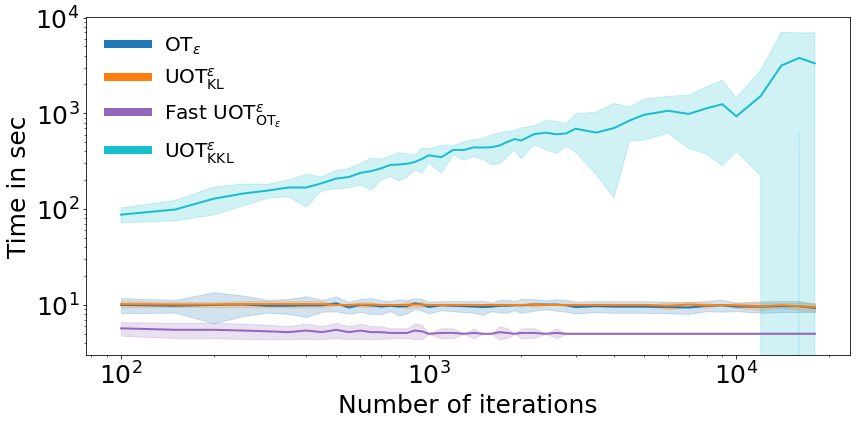

In [9]:
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]

pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p=="balanced" or p== "kl" or p =="sinkhorn_1iter" or p=="kkl": 
        pl.plot(n_l,res_mean[:,i],c="C%i"%i,linewidth=2)
        pl.fill_between(n_l, res_mean[:,i] -  2*res_std[:,i], res_mean[:,i] + 2*res_std[:,i], alpha=0.2,color="C%i"%i)
        

handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label5,label10]) 
pl.yscale("log")
pl.xscale("log")
pl.xlabel('Number of iterations',fontsize=25)
pl.ylabel('Time in sec',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.tight_layout()
pl.legend(frameon=False,bbox_to_anchor=(.28,1),handles=handles, prop={'size': 20})
pl.savefig("../../Figures/UOT/Nb_iter_uot_ot_kkl.pdf",bbox_inches='tight')

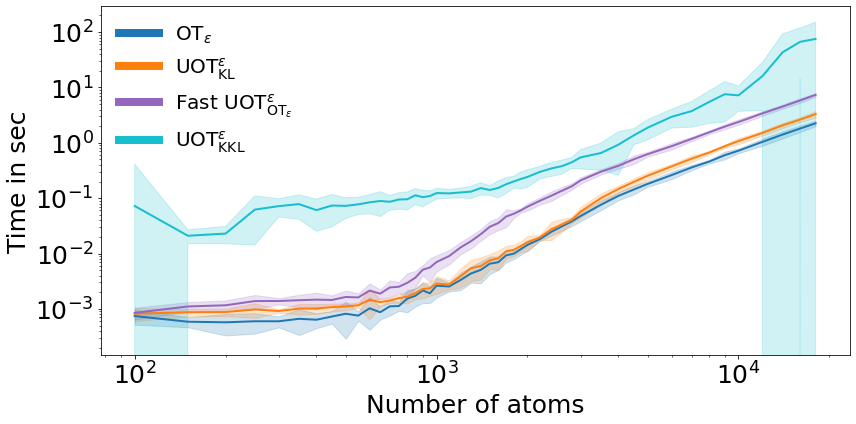

In [10]:
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]

pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p=="balanced" or p== "kl" or p =="sinkhorn_1iter" or p=="kkl": 
        pl.plot(n_l,rest_mean[:,i],c="C%i"%i,linewidth=2)
        pl.fill_between(n_l, rest_mean[:,i] -  2*rest_std[:,i], rest_mean[:,i] + 2*rest_std[:,i], alpha=0.2,color="C%i"%i)
        

handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label5,label10]) 
pl.yscale("log")
pl.xscale("log")
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Time in sec',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.tight_layout()
pl.legend(frameon=False,bbox_to_anchor=(.28,1),handles=handles, prop={'size': 20})
pl.savefig("../../Figures/UOT/Computationtimming_uot_ot_kkl.pdf",bbox_inches='tight')

# All

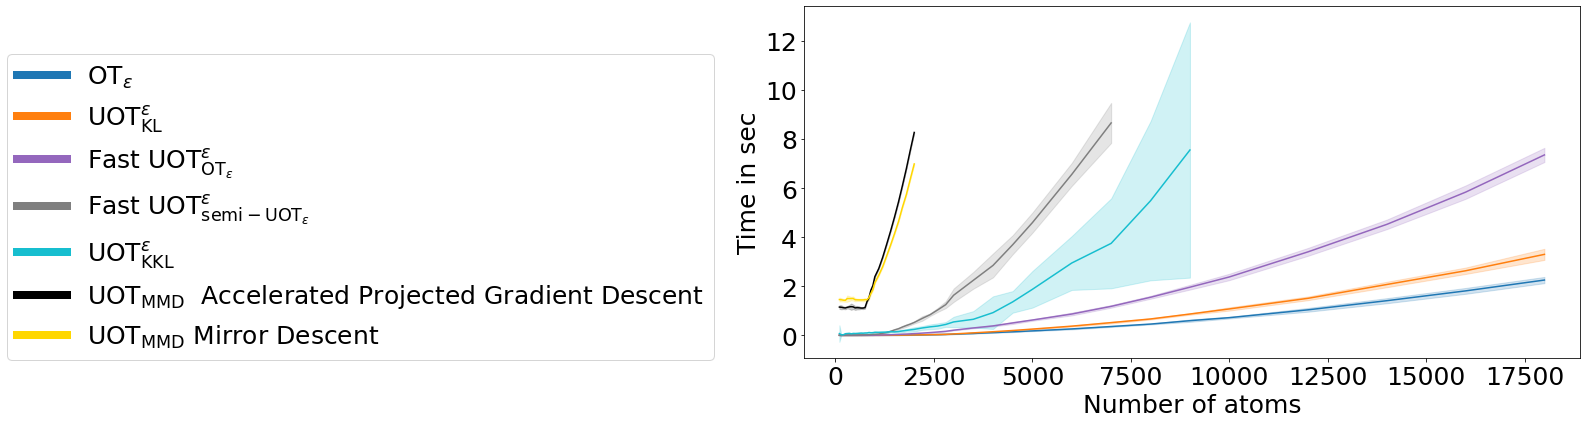

In [173]:
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]
pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p !="sinkhorn" and p !="warm_sinkhorn" and p!="UOT_sinkhorn" and p!="warm_UOT_sinkhorn" and p!='LOT': 
        if p!="MMD" and p!="MMD2" and p!="UOT_sinkhorn_1iter" and p!="kkl":
            pl.plot(n_l,rest_mean[:,i],c="C%i"%i)
            pl.fill_between(n_l, rest_mean[:,i] -  rest_std[:,i], rest_mean[:,i] + rest_std[:,i], alpha=0.2,color="C%i"%i)
        if p=="UOT_sinkhorn_1iter":
            pl.plot(n_l[:40],rest_mean[:40,i],c="C%i"%i)
            pl.fill_between(n_l[:40], rest_mean[:40,i] -  2*rest_std[:40,i], rest_mean[:40,i] + 2*rest_std[:40,i], alpha=0.2,color="C%i"%i)
        if p=="kkl":
            pl.plot(n_l[:42],rest_mean[:42,i],c="C%i"%i)
            pl.fill_between(n_l[:42], rest_mean[:42,i] -  2*rest_std[:42,i], rest_mean[:42,i] + 2*rest_std[:42,i], alpha=0.2,color="C%i"%i)
        if p=="MMD":
            pl.plot(n_l[:29],rest_mean[:29,i],c="black")
            pl.fill_between(n_l[:29], rest_mean[:29,i] -  2*rest_std[:29,i], rest_mean[:29,i] + 2*rest_std[:29,i], alpha=0.2,color="black")
        if p=="MMD2":
            pl.plot(n_l[:29],rest_mean[:29,i],c="gold")
            pl.fill_between(n_l[:29], rest_mean[:29,i] -  2*rest_std[:29,i], rest_mean[:29,i] + 2*rest_std[:29,i], alpha=0.2,color="gold")
            
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label5,label8,label10,label11,label12])
#pl.yscale("log")
#pl.xscale("log")
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Time in sec',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.tight_layout()
pl.legend(bbox_to_anchor=(-.1,.9),handles=handles, prop={'size': 25})
pl.savefig("../../Figures/UOT/ComputationAll1.pdf",bbox_inches='tight')

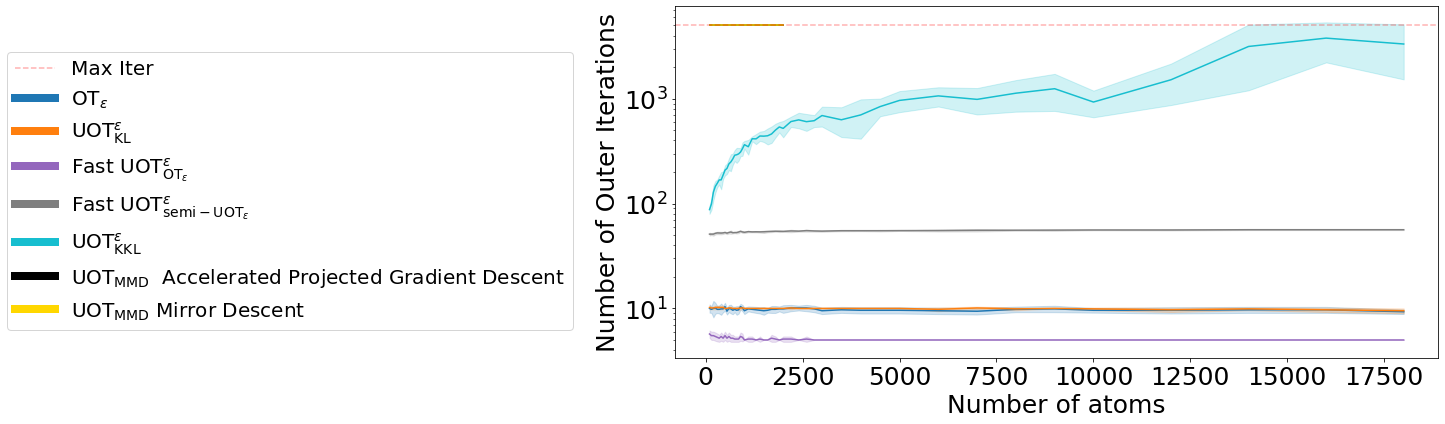

In [174]:
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]
pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p !="sinkhorn" and p !="warm_sinkhorn" and p!="UOT_sinkhorn" and p!="warm_UOT_sinkhorn" and p!='LOT': 
        if p!="MMD" and p!="MMD2":
            pl.plot(n_l,res_mean[:,i],c="C%i"%i)
            pl.fill_between(n_l, res_mean[:,i] -  res_std[:,i], res_mean[:,i] + res_std[:,i], alpha=0.2,color="C%i"%i) 
        if p=="MMD":
            pl.plot(n_l[:29],res_mean[:29,i],c="black")
            pl.fill_between(n_l[:29], res_mean[:29,i] -  2*res_std[:29,i], res_mean[:29,i] + 2*res_std[:29,i], alpha=0.2,color="black")
        if p=="MMD2":
            pl.plot(n_l[:29],res_mean[:29,i],c="gold")
            pl.fill_between(n_l[:29], res_mean[:29,i] -  2*res_std[:29,i], res_mean[:29,i] + 2*res_std[:29,i], alpha=0.2,color="gold")
            
pl.axhline(y=int(5e3), color='r', linestyle='--',alpha=0.3,label='Max Iter')
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label5,label8,label10,label11,label12])
pl.yscale("log")
#pl.xscale("log")
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Number of Outer Iterations',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.tight_layout()
pl.legend(bbox_to_anchor=(-.12,.9),handles=handles, prop={'size': 20})
pl.savefig("../../Figures/UOT/ComputationAll2.pdf",bbox_inches='tight')

# Inner Iter

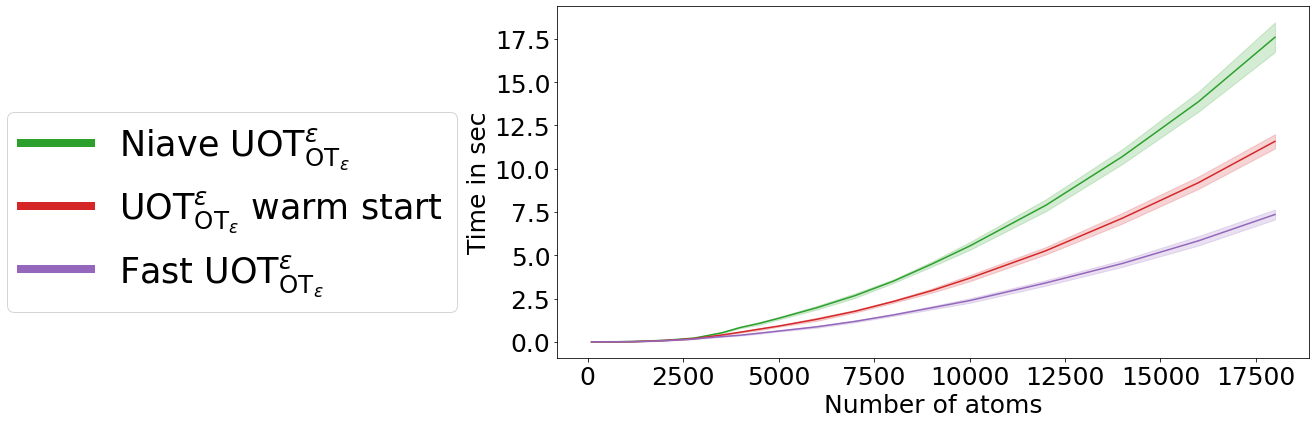

In [175]:
# Timming
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]
pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p=="sinkhorn" or p=="warm_sinkhorn" or p=="sinkhorn_1iter":
        pl.plot(n_l,rest_mean[:,i],c="C%i"%i)
        pl.fill_between(n_l, rest_mean[:,i] -  rest_std[:,i], rest_mean[:,i] + rest_std[:,i], alpha=0.2,color="C%i"%i)
    
#pl.yscale('log')
#pl.xscale("log")
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label3,label4,label5])   
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Time in sec',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
#pl.yscale("log")
#pl.xscale("log")
pl.tight_layout()
pl.legend(bbox_to_anchor=(-.11,.75),handles=handles, prop={'size': 35})
pl.savefig("../../Figures/UOT/ComputationSinkhorn1.pdf",bbox_inches='tight')

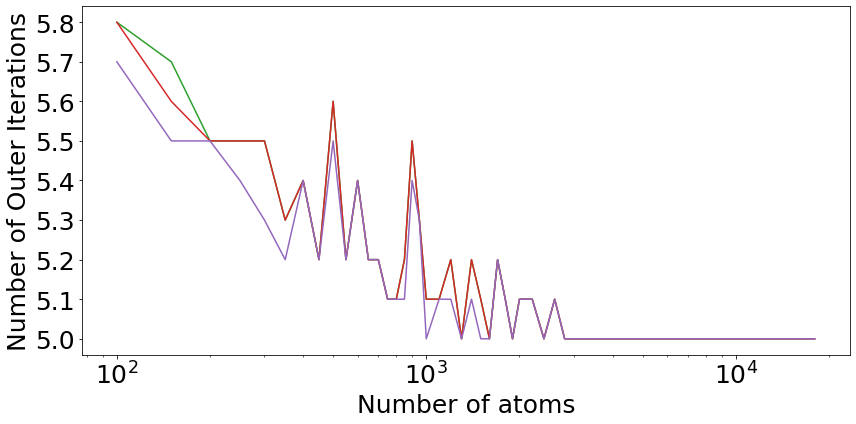

In [176]:
# Outer iterations
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","LOT","kkl","MMD","MMD2"]
pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p=="sinkhorn" or p=="warm_sinkhorn" or p=="sinkhorn_1iter":
        pl.plot(n_l,res_mean[:,i],c="C%i"%i)
        #pl.fill_between(n_l, res_mean[:,i] -  res_std[:,i], res_mean[:,i] + res_std[:,i], alpha=0.2,color="C%i"%i)
    
pl.xscale("log") 
#pl.yscale("log")
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Number of Outer Iterations',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.tight_layout()
pl.savefig("../../Figures/UOT/ComputationSinkhorn2.pdf",bbox_inches='tight')

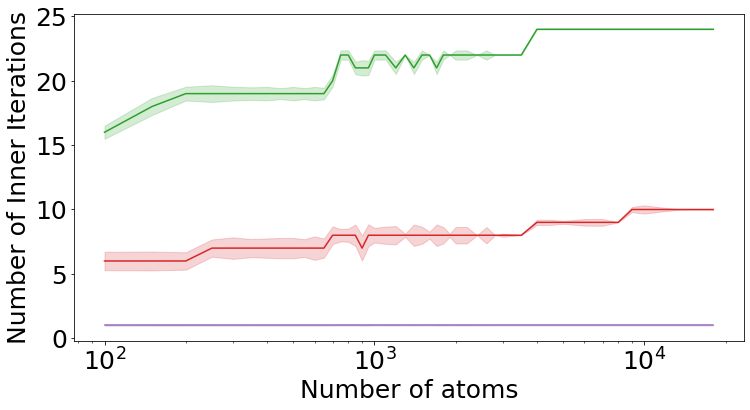

In [177]:
# Inner iterations
pen=["balanced","kl","sinkhorn","warm_sinkhorn","sinkhorn_1iter",
    "UOT_sinkhorn","warm_UOT_sinkhorn","UOT_sinkhorn_1iter","MMD"]
pl.figure(figsize=(12,6))
for i,p in enumerate(pen):
    if p=="sinkhorn" or p=="warm_sinkhorn" or p=="sinkhorn_1iter":
        #for j in steps:
            #pl.text(n_l[j],resin_mean[j,i]+.5,s=resin_mean[j,i],c="C%i"%i,ha="center",va="center")
        pl.plot(n_l,resin_mean[:,i],c="C%i"%i)
        pl.fill_between(n_l, resin_mean[:,i] -  2*resin_std[:,i], resin_mean[:,i] + 2*resin_std[:,i], alpha=0.2,color="C%i"%i)
    
pl.xscale("log")
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Number of Inner Iterations',fontsize=25)
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.savefig("../../Figures/UOT/ComputationSinkhorn3.pdf",bbox_inches='tight')

In [23]:
import cvxpy as cp
def UOT_W(a,b,C,lam,lam2=None,Cx=None,Cy=None,innerplan=False,solver="ECOS",thr=1e-5):
    
    if lam2 is None:
        lam2=lam

    n,m=C.shape
    pi = cp.Variable((n,m))
    Qx=cp.Variable((n,n))
    Qy=cp.Variable((m,m))

    ### penalization Wasserstein ###
    objective = cp.Minimize(cp.sum(cp.multiply(pi,C))
                +lam*cp.sum(cp.multiply(Qx,Cx))
                +lam2*cp.sum(cp.multiply(Qy,Cy)))
    constraints = [pi>=0,Qx>=0,Qy>=0,
                   Qx@torch.ones(n)==pi@torch.ones(m),
                   Qy@torch.ones(m)==(pi.T)@torch.ones(n),
                   Qx.T@torch.ones(n)==a,
                   Qy.T@torch.ones(m)==b]

    prob = cp.Problem(objective, constraints)
    result = prob.solve(solver=solver,verbose=False,abstol=thr)
    if innerplan:
        return pi.value,Qx.value,Qy.value
    else:
        return pi.value

In [181]:
n_seed=10
pen=["sinkhorn","linear_solver"]
n_l=[100,150,200,250,300,350,400,450,500,550,600,650,700]
result_time=np.zeros((n_seed,len(n_l),len(pen)))

In [23]:
for i in range(n_seed):
    print(i,end=" : ")
    for j,n in enumerate(n_l):
        print(n,end=" ")
        X,Y=make_data('gaussians',n,dim=2)
        X=X.to(device)
        Y=Y.to(device)
        a=torch.ones((n,))/n
        b=torch.ones((n,))/n
        a=a.to(device)
        b=b.to(device)
        C=ot.dist(X,Y)
        Cx=ot.dist(X,X)
        Cy=ot.dist(Y,Y)
        for k,p in enumerate(pen):
            if p=="linear_solver":
                start = time.time()
                _=UOT_W(a,b,C,lam=5,Cx=Cx,Cy=Cy,innerplan=False,thr=1e-3)
            else:
                start = time.time()
                _,_=sinkhorn(a,b,C,lam=5,eps=3,numiter=int(5e3),pen="sinkhorn_1iter",
                         Cx=Cx,Cy=Cy,lam3=None,eps2=6,numiter2=int(1e3),thr=1e-3)

            result_time[i,j,k]= time.time()-start
    print()

0 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
1 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
2 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
3 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
4 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
5 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
6 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
7 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
8 : 100 150 200 250 300 350 400 450 500 550 600 650 700 
9 : 100 150 200 250 300 350 400 450 500 550 600 650 700 


In [26]:
#np.savetxt("result/computation_timing/result_time3.txt",result_time.reshape(result_time.shape[0],-1))

In [185]:
result_time=np.loadtxt("result/computation_timing/result_time3.txt").reshape(10,13,2)

In [186]:
rest_mean=np.mean(result_time,0)
rest_std=np.std(result_time,0)

# COMPARAISON SINKHORN vs LINEAR SOLVER

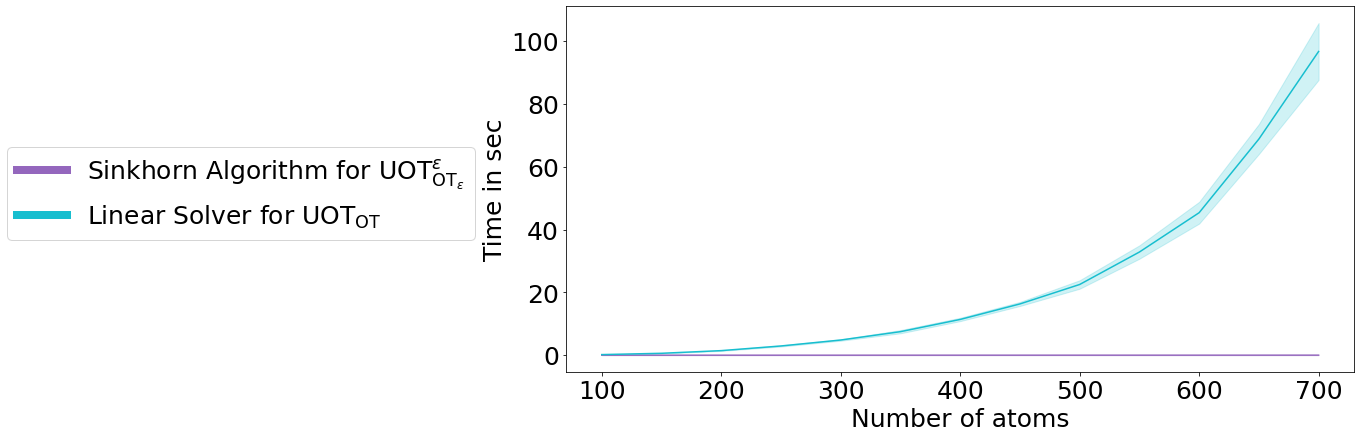

In [191]:
# Timming
pl.figure(figsize=(12,6))
pl.plot(n_l,rest_mean[:,0],c="C4")
pl.fill_between(n_l, rest_mean[:,0] -  rest_std[:,0], rest_mean[:,0] + rest_std[:,0], alpha=0.2,color="C4")
pl.plot(n_l,rest_mean[:,1],c="C9")
pl.fill_between(n_l, rest_mean[:,1] -  rest_std[:,1], rest_mean[:,1] + rest_std[:,1], alpha=0.2,color="C9")
    
#pl.yscale('log')
#pl.xscale("log")
label1 = Line2D([0], [0], label="Sinkhorn Algorithm for $\mathrm{UOT}^\epsilon_{\mathrm{OT}_\epsilon}$", color='C4', linestyle='-',linewidth=8)
label2 = Line2D([0], [0], label="Linear Solver for $\mathrm{UOT}_\mathrm{OT}$", color='C9', linestyle='-',linewidth=8)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.xlabel('Number of atoms',fontsize=25)
pl.ylabel('Time in sec',fontsize=25)
#pl.yscale("log")
#pl.xscale("log")
pl.tight_layout()
pl.xticks(fontsize = 25)
pl.yticks(fontsize = 25)
pl.legend(bbox_to_anchor=(-.1,.65),handles=handles, prop={'size': 25})
pl.savefig("../../Figures/UOT/ComputationSinkhornvsLinear.pdf",bbox_inches='tight')